In [72]:
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.cubehelix_palette(6, start=.5, rot=-.75))

from sklearn.model_selection import (train_test_split, StratifiedKFold, KFold, GridSearchCV)

from sklearn.metrics import (roc_auc_score, roc_curve)

# machine learning libraries
from xgboost import XGBClassifier

import utils
from preprocessing import (format_columns, 
                           create_cohort, 
                           create_target, 
                           drop_anomalous_cycles)

from modelling import (create_training_test,
                       fit_model,
                       tune_model)

colors = sns.color_palette()

age_groups = ['18-34', '35-37', '38-39', '40-42', '43-44', '45-50']

# Notebook introduction


To write.

# 0. Load the data and create the cohort

In [2]:
df = pd.read_csv('data/ar-2015-2016.csv')

df = (df.pipe(format_columns)
        .pipe(create_cohort)
        .pipe(create_target)
        .pipe(drop_anomalous_cycles))

print(df.shape)

c:\users\fpc\envs\ivf\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (6,7,29,31,32,43,48,50,51,52,53,54,77,83,89,90,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(86169, 96)


## 0.1 Number of patients in each class

In [476]:
df.groupby('target')['Patient Age at Treatment'].count()

target
0.0    37577
1.0    49875
Name: Patient Age at Treatment, dtype: int64

## 0.2 Number of patients in each age group

In [477]:
df.groupby('Patient Age at Treatment')['target'].count()

Patient Age at Treatment
18-34    37826
35-37    20154
38-39    12989
40-42    12242
43-44     3266
45-50      975
Name: target, dtype: int64

# 1 Initial data analysis

## 1.1 Number of eggs collected by age group

Outliers are not shown since the distributions have such long tails.

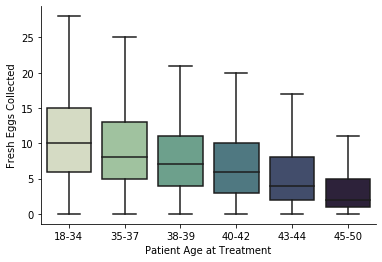

In [389]:
fig, ax = plt.subplots()
sns.boxplot(x='Patient Age at Treatment', y='Fresh Eggs Collected', ax=ax, data=df,
           order=age_groups, showfliers=False)

utils.remove_axes(ax)
plt.savefig('images/eggs_collected_by_age.png', dpi=300, bbox_inches='tight')

## 1.2 Proportion of patients with suitable embryos by Number eggs collected

Non-linear relation between number of embryos suitable for D5 transfer or freezing and number of eggs collected. Overall a very strong relation. 

Panel b, highlights that age is an additional factor (older patients have a reduced chance of the cycle yielding a suitable embryo, even if they have the same number of eggs as a younger person).

AttributeError: module 'utils' has no attribute 'calculate_proportion_error'

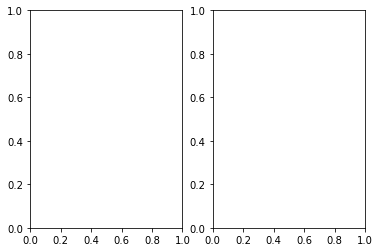

In [73]:
fig, axs = plt.subplots(ncols=2)


# plot for all patients
egg_outcome = df.groupby('Fresh Eggs Collected')['target'].agg(['mean','count'])
mean_error = utils.calculate_proportion_error(egg_outcome['mean'].values, egg_outcome['count'].values)

utils.plot_line_with_confidence(x=egg_outcome.index,
                          y=egg_outcome['mean'].values*100,
                          err=mean_error*100,
                          ax=axs[0], 
                          plot_params={'color':colors[-1], 'lw':1.5},
                          fill_params={'color':colors[-2], 'alpha':0.35})

# plot for segregated by age
for age in age_groups[:-1]:
    mask = df['Patient Age at Treatment']==age
    egg_outcome = df[mask].groupby('Fresh Eggs Collected')['target'].agg(['mean','count'])
    mean_error = utils.calculate_proportion_error(egg_outcome['mean'].values, egg_outcome['count'].values)

    utils.plot_line_with_confidence(x=egg_outcome.index,
                              y=egg_outcome['mean'].values*100,
                              err=mean_error*100,
                              ax=axs[1], 
                              plot_params={'label':age, 'lw':1.5},
                              fill_params={'alpha':0.35})
    
# tidy up plots and add labels
axs[1].legend(fontsize=9)
plt.setp(axs[1].get_yticklabels(), visible=False)
axs[0].set_ylabel('Treatment cycles with \nat least one D5 embryo (%)')
for ax in axs:
    ax.set_xlabel('Number of eggs collected')
fig.set_size_inches(5,2.5)
axs[0].text(0,90,'a)')
plt.savefig('images/cycles_with_suitable_embryos.png', dpi=300, bbox_inches='tight')

## 1.3 Proportion of patients with suitable embryos by age group

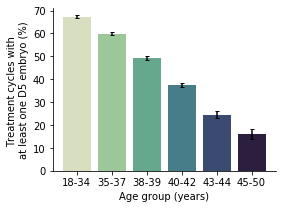

In [8]:
age_grouping = df.groupby('Patient Age at Treatment')['target'].agg(['mean', 'count'])


x = age_grouping.index
y = age_grouping['mean'].values
c = age_grouping['count'].values

errors  =  1.96 *  ((y * (1-y)) / c) **0.5

# plot the figure

fig, ax = plt.subplots()

ax.bar(np.arange(0,len(y)), y*100, yerr=errors*100, capsize=2, color=colors)
ax.set_ylabel('Treatment cycles with \nat least one D5 embryo (%)')
utils.remove_axes(ax)

# set the xtick labels
ax.set_xticklabels([''] + age_groups)
ax.set_xlabel('Age group (years)')

fig.set_size_inches(4,3)
plt.savefig('images/cycles_with_embryos_by_age_group.png', dpi=300, bbox_inches='tight')

## 1.4 Proportion of patients with suitable embryos by infertility diagnosis

In [399]:
infertility_columns = [col for col in df.columns if col.startswith('Cause of Infertility')]

c:\users\fpc\envs\ivf\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\fpc\envs\ivf\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


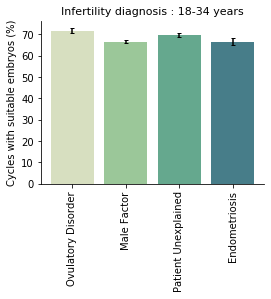

In [456]:
means = []
errors = []

age='18-34'

for col in infertility_columns:
    mask = (df[col]==1) & (df['Patient Age at Treatment']==age)
    infertility_target = df.loc[mask, 'target'].values
    mean_embryos = np.mean(infertility_target)
    count_embryos = len(infertility_target)
    error = 1.96 *  ((mean_embryos * (1-mean_embryos)) / count_embryos) **0.5
    means.append(mean_embryos)
    errors.append(error)
    
# make the figure
xlabels = [col.replace('Cause of Infertility - ', '') for col in infertility_columns]


fig, ax = plt.subplots()
ax.bar(xlabels[:4], np.array(means[:4])*100, yerr=np.array(errors[:4])*100, capsize=2, color=colors[:4])
utils.remove_axes(ax)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title('Infertility diagnosis : {} years'.format(age), fontsize=11)
ax.set_ylabel('Cycles with suitable embryos (%)')
fig.set_size_inches(4,3)

plt.savefig('images/cycles_with_embryos_by_infertility_diagnosis_{}.png'.format(age), dpi=300, bbox_inches='tight')

## 1.5 By Type of treatment

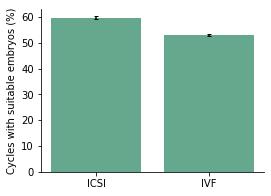

In [498]:
treatment_types = df.groupby('Specific treatment type')['target'].agg(['mean','count'])

x = treatment_types.index
y = treatment_types['mean'].values
c = treatment_types['count'].values

errors  =  1.96 *  ((y * (1-y)) / c) **0.5

# plot the figure

fig, ax = plt.subplots()

ax.bar(x, y*100, yerr=errors*100, color=colors[-4], capsize=2)
ax.set_ylabel('Cycles with suitable embryos (%)')
utils.remove_axes(ax)

fig.set_size_inches(4,3)
plt.savefig('images/cycles_with_embryos_by_type_of_treatment.png', dpi=300, bbox_inches='tight')

# 2.0 Modelling


In [633]:
df = encode_columns(df)

In [634]:
X, Xt, y, yt = create_training_test(df)

## 2.1 Model 1

Uses only one features
    - Patient Age

In [624]:
infertility_columns = [col for col in df.columns if col.startswith('Cause of Infertility')]
features = ['Patient Age at Treatment','Fresh Eggs Collected', 'Specific treatment type',infertility_columns[:4]]

In [638]:
# perform boot strapping for errors 
for feature in features:
    X, Xt, y, yt = create_training_test(df, features=feature)
    ncycles = 100
    scores = np.zeros(ncycles)
    for i in range(ncycles):
        bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
        X_bs = X[bs_idx]
        y_bs = y[bs_idx]
        # if only one feature add additional dimension
        try:
            X_bs.shape[1]
        except:
            X_bs = X_bs.reshape((-1,1))
            Xt = Xt.reshape((-1,1))
        models, score = fit_model(X_bs, y_bs, cv_splitter=KFold)
        scores[i] = score
    confidence = utils.confidence_intervals(scores)
    print('----*----')
    print(feature)
    print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

----*----
Patient Age at Treatment
AUROC: 0.635 CI: 0.631-0.639
----*----
Fresh Eggs Collected
AUROC: 0.838 CI: 0.835-0.841
----*----
Specific treatment type
AUROC: 0.533 CI: 0.530-0.536
----*----
['Cause of Infertility - Ovulatory Disorder', 'Cause of Infertility - Male Factor', 'Cause of Infertility - Patient Unexplained', 'Cause of Infertility - Endometriosis']
AUROC: 0.549 CI: 0.545-0.552


### 2.1.1 Model 1.1

Age and number of eggs


In [690]:
features = ['Patient Age at Treatment','Fresh Eggs Collected']

In [697]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)
ncycles = 100
scores = np.zeros(ncycles)
for i in range(ncycles):
    bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
    X_bs = X[bs_idx]
    y_bs = y[bs_idx]
    models, score = fit_model(X_bs, y_bs, cv_splitter=KFold)
    scores[i] = score
confidence = utils.confidence_intervals(scores)
print('----*----')
print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

----*----
AUROC: 0.843 CI: 0.840-0.846


### 2.1.2  Model 1.2

In [641]:
features = ['Patient Age at Treatment','Fresh Eggs Collected', 'Specific treatment type']

In [642]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)
ncycles = 100
scores = np.zeros(ncycles)
for i in range(ncycles):
    bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
    X_bs = X[bs_idx]
    y_bs = y[bs_idx]
    models, score = fit_model(X_bs, y_bs, cv_splitter=KFold)
    scores[i] = score
confidence = utils.confidence_intervals(scores)
print('----*----')
print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

----*----
AUROC: 0.844 CI: 0.842-0.847


### 2.1.3 Model 1.3

In [643]:
features = ['Patient Age at Treatment','Fresh Eggs Collected'] + infertility_columns[:4]

In [644]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)
ncycles = 100
scores = np.zeros(ncycles)
for i in range(ncycles):
    bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
    X_bs = X[bs_idx]
    y_bs = y[bs_idx]
    models, score = fit_model(X_bs, y_bs, cv_splitter=KFold)
    scores[i] = score
confidence = utils.confidence_intervals(scores)
print('----*----')
print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

----*----
AUROC: 0.845 CI: 0.842-0.848


### 2.14 Model 1.4

In [645]:
features = ['Patient Age at Treatment','Fresh Eggs Collected', 'Specific treatment type'] + infertility_columns[:4]

In [646]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)
ncycles = 100
scores = np.zeros(ncycles)
for i in range(ncycles):
    bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
    X_bs = X[bs_idx]
    y_bs = y[bs_idx]
    models, score = fit_model(X_bs, y_bs, cv_splitter=KFold)
    scores[i] = score
confidence = utils.confidence_intervals(scores)
print('----*----')
print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

----*----
AUROC: 0.845 CI: 0.842-0.848


# 3. Hyperparameter tuning and final model evaluation

In [649]:
features = ['Patient Age at Treatment','Fresh Eggs Collected'] + infertility_columns[:4]

In [651]:
param_grid =  {'max_depth':[2,3,4],'subsample':[1,0.9, 0.8], 'gamma':[1,5,10,25], 'learning_rate':[0.05,0.025,0.1], 'n_estimators':[75,100, 125]}

In [655]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)

hyperparameters = tune_model(X, y, param_grid=param_grid)

In [657]:
hyperparameters.best_params_

{'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.8}

In [661]:
np.save('results/y_true_xgboost.npy', yt)

# 3.1 Train the final model

- Bootstrapping is performed and the model evaluated on the hold-out test
- Best hyperparameters on the validation set is used.

In [668]:
# perform boot strapping for errors
X, Xt, y, yt = create_training_test(df, features=features)
ncycles = 250
scores = np.zeros(ncycles)
yt_preds_list = []
for i in range(ncycles):
    bs_idx = np.random.randint(low=0, high=len(X), size=len(X))
    X_bs = X[bs_idx]
    y_bs = y[bs_idx]
    models, score = fit_model(X_bs, y_bs, cv_splitter=KFold, params=hyperparameters.best_params_)
    yt_preds = np.zeros(len(Xt))
    for model in models:
        yt_preds += model.predict_proba(Xt)[:,1]/len(models)
    scores[i] = roc_auc_score(yt, yt_preds)
    yt_preds_list.append(yt_preds)
confidence = utils.confidence_intervals(scores)
print('----*----')
print('AUROC: {0:.3f} CI: {1:.3f}-{2:.3f}'.format(np.mean(scores), confidence[0], confidence[1]))

np.save('results/y_preds_xgboost.npy', yt_preds_list)

----*----
AUROC: 0.841 CI: 0.840-0.841


## 3.2 Figures of merit on hold-out test set

In [674]:
bs_preds = np.load('results/y_preds_xgboost.npy')

In [676]:
mean_preds = np.mean(bs_preds, axis=0)
fpr, tpr, _ = roc_curve(yt, mean_preds)

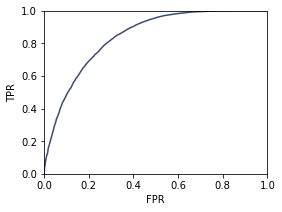

In [682]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color=colors[-2])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

fig.set_size_inches(4,3)
plt.savefig('images/HFEA_model_evaluation_ROC.png', dpi=300, bbox_inches='tight')

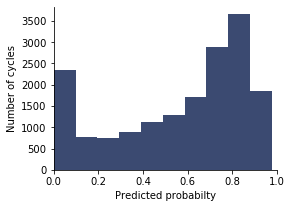

In [689]:
fig, ax = plt.subplots()

ax.hist(mean_preds, color=colors[-2])
ax.set_xlabel('Predicted probabilty')
ax.set_ylabel('Number of cycles')
ax.set_xlim(0,1)
utils.remove_axes(ax)

fig.set_size_inches(4,3)
plt.savefig('images/HFEA_model_predictions.png', dpi=300, bbox_inches='tight')